In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, optimizers, applications, losses, utils #experimental
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score, precision_score, recall_score

#from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50, ResNet50V2, InceptionV3

from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

# ignoring warnings
import warnings
warnings.simplefilter("ignore")


In [ ]:
os.listdir(os.getcwd()+"/drive/MyDrive/Msc_Project/ISIC_2008_challenge_3")

['ISIC2018_Task3_Test_GroundTruth.csv',
 'HAM10000_metadata.csv',
 'HAM10000_metadata',
 'ISIC2018_Task3_Validation_GroundTruth.csv',
 'ISIC2018_Task3_Test_Images',
 'HAM10000_images',
 'ISIC2018_Task3_Validation_GroundTruth',
 'ISIC2018_Task3_Validation_Input']

In [ ]:
#ORI_DIR = os.getcwd()+"\ISIC_2008_challenge_3"
ORI_DIR = os.getcwd()+"/drive/MyDrive/Msc_Project/ISIC_2008_challenge_3"
os.listdir(ORI_DIR)

['ISIC2018_Task3_Test_GroundTruth.csv',
 'HAM10000_metadata.csv',
 'HAM10000_metadata',
 'ISIC2018_Task3_Validation_GroundTruth.csv',
 'ISIC2018_Task3_Test_Images',
 'HAM10000_images',
 'ISIC2018_Task3_Validation_GroundTruth',
 'ISIC2018_Task3_Validation_Input']

In [ ]:
train_metadata = os.path.join(ORI_DIR, 'HAM10000_metadata.csv')
test_metadata = os.path.join(ORI_DIR, 'ISIC2018_Task3_Test_GroundTruth.csv')

In [ ]:

#PRO_DIR = os.getcwd()+"\Processed_images"
PRO_DIR = os.getcwd()+"/drive/MyDrive/Msc_Project/Processed_images"
os.listdir(PRO_DIR)

['train', 'test']

In [ ]:
pro_train_images_dir =os.path.join(PRO_DIR, 'train')
pro_test_images_dir =os.path.join(PRO_DIR, 'test')

In [ ]:
print('Processed Train images: %d' %len(os.listdir(pro_train_images_dir)))

Processed Train images: 10015


In [ ]:
print('Processed Test images: %d' %len(os.listdir(pro_test_images_dir)))

Processed Test images: 1511


In [ ]:
train_df = pd.read_csv(train_metadata)
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
test_df = pd.read_csv(test_metadata)
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAMTEST_0000000,ISIC_0034524,nv,follow_up,40.0,female,back,vidir_molemax
1,HAMTEST_0000001,ISIC_0034525,nv,histo,70.0,male,abdomen,rosendahl
2,HAMTEST_0000002,ISIC_0034526,bkl,histo,70.0,male,back,rosendahl
3,HAMTEST_0000003,ISIC_0034527,nv,histo,35.0,male,trunk,vienna_dias
4,HAMTEST_0000004,ISIC_0034528,nv,follow_up,75.0,female,trunk,vidir_molemax


In [ ]:
name_dict = {
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevus',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesion'
}

In [ ]:
label_dict = {
    'mel': '0',
    'nv': '1',
    'bcc': '2',
    'akiec': '3',
    'bkl': '4',
    'df': '5',
    'vasc': '6'
}

In [ ]:
train_df['name'] = train_df['dx'].map(name_dict.get)
train_df['label'] = train_df['dx'].map(label_dict.get)

test_df['name'] = test_df['dx'].map(name_dict.get)
test_df['label'] = test_df['dx'].map(label_dict.get)

In [ ]:
train_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,name,label
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,Actinic keratosis,3
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern,Melanoma,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
 8   name          10015 non-null  object 
 9   label         10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [ ]:
train_df['label'] = train_df['dx'].map(label_dict)
test_df['label'] = test_df['dx'].map(label_dict)

In [ ]:
# Convert labels to string to use with ImageDataGenerator
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:
train_df['image_id'] = train_df['image_id'] + '.jpg'
test_df['image_id'] = test_df['image_id'] + '.jpg'

In [ ]:
train_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,name,label
10010,HAM_0002867,ISIC_0033084.jpg,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10011,HAM_0002867,ISIC_0033550.jpg,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10012,HAM_0002867,ISIC_0033536.jpg,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10013,HAM_0000239,ISIC_0032854.jpg,akiec,histo,80.0,male,face,vidir_modern,Actinic keratosis,3
10014,HAM_0003521,ISIC_0032258.jpg,mel,histo,70.0,female,back,vidir_modern,Melanoma,0


In [ ]:
label_dict = {value: key for key, value in label_dict.items()}
label_dict

{'0': 'mel',
 '1': 'nv',
 '2': 'bcc',
 '3': 'akiec',
 '4': 'bkl',
 '5': 'df',
 '6': 'vasc'}

In [ ]:
class_indices = list(label_dict.keys())

# Convert label_dict to a list of class names in the correct order
target_names = [label_dict[idx] for idx in class_indices]

In [ ]:
target_names

['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']

In [ ]:
class_indices

['0', '1', '2', '3', '4', '5', '6']

# Transfer Learning no fine tunning

In [ ]:
# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 50

In [ ]:
# Load the pre-trained ResNet50 model, exclude top layers
#base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))


# Freeze all layers in the base model
base_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)


In [ ]:
# Build the final model
transfer_model = Model(inputs=base_model.input, outputs=output)

In [ ]:
#optimizer_ = Adam(learning_rate=0.0001)
optimizer_ = tf.keras.optimizers.Adamax(learning_rate=0.0001)
#optimizer_ = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)


In [ ]:
# Compile the model
transfer_model.compile(
    optimizer=optimizer_,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    #metricvs=['accuracy']
)

In [ ]:
# callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
# Print the model architecture
transfer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,670,151 (97.92 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Split into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
#Data augmentation for training and set up for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=pro_train_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=pro_train_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Test data generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=pro_test_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1511 validated image filenames belonging to 7 classes.


In [ ]:
# Train the model
transfer_history = transfer_model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 205s 728ms/step - accuracy: 0.8391 - loss: 0.4324 - precision: 0.8783 - recall: 0.8076 - val_accuracy: 0.7954 - val_loss: 0.5726 - val_precision: 0.8356 - val_recall: 0.7762 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8438 - loss: 0.3451 - precision: 0.8889 - recall: 0.7500 - val_accuracy: 0.6842 - val_loss: 0.8383 - val_precision: 0.6842 - val_recall: 0.6842 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 688ms/step - accuracy: 0.8525 - loss: 0.3987 - precision: 0.8863 - recall: 0.8204 - val_accuracy: 0.8019 - val_loss: 0.5980 - val_precision: 0.8289 - val_recall: 0.7812 - learning_rate: 1.0000e-04
Epoch 4/50
  1/250 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - accuracy: 0.8750 - loss: 0.3704 - precision: 0.9032 - recall: 0.8750
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.8750 - loss: 0.3704

In [ ]:

# Evaluate the model on the validation/test set
#val_loss, val_accuracy = transfer_model.evaluate(val_generator)
#print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
val_loss, val_accuracy, val_precision, val_recall = transfer_model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.7830 - loss: 0.5980 - precision: 0.8311 - recall: 0.7615
Validation Loss: 0.5751177668571472, Validation Accuracy: 0.7943085432052612, Validation Precision: 0.83404940366745, Validation Recall: 0.7753369808197021


In [ ]:
acc = transfer_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy']

loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']


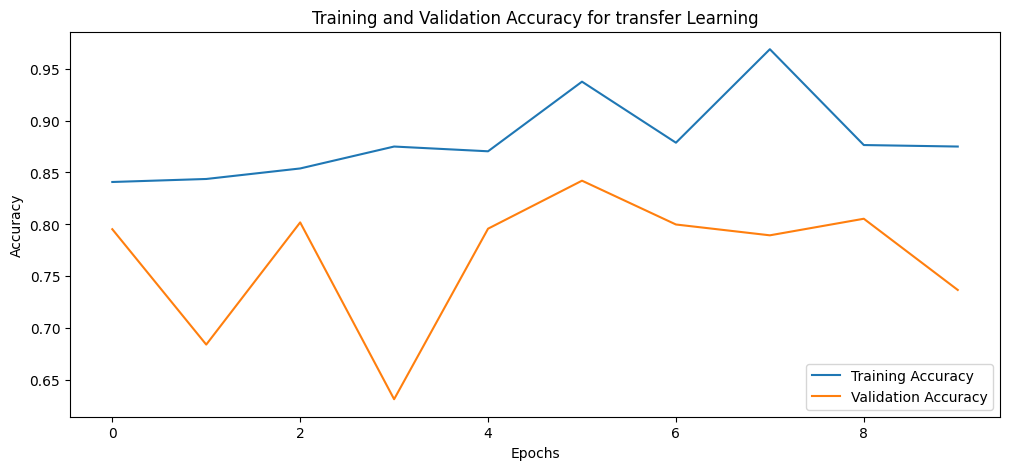

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.title('Training and Validation Accuracy for transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()


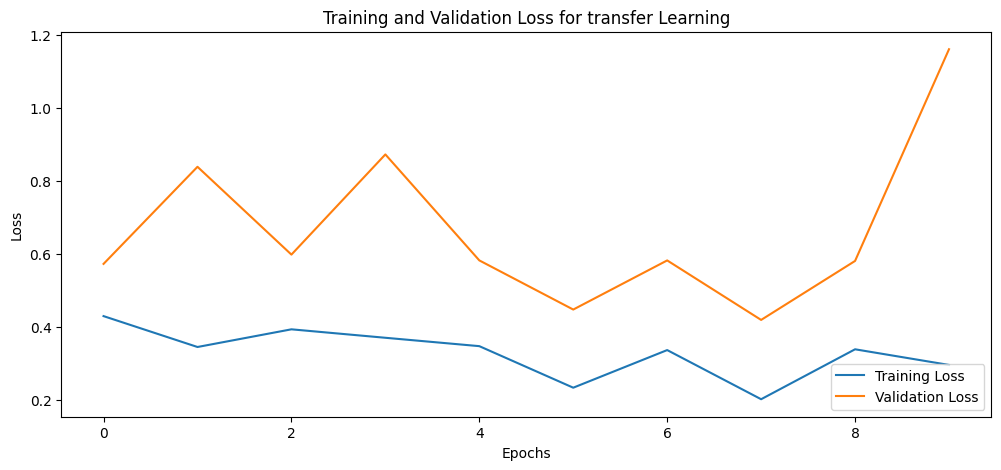

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.plot( loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss for transfer Learning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:

# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = transfer_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step


In [ ]:

len(predicted_classes)

1511

In [ ]:

# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes

array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy
#print(f'Accuracy: {accuracy:.2f}')



0.7511581733951026

In [ ]:
"""
class_indices = list(label_dict.keys())

# Convert label_dict to a list of class names in the correct order
target_names = [label_dict[idx] for idx in class_indices]
"""

'\nclass_indices = list(label_dict.keys())\n\n# Convert label_dict to a list of class names in the correct order\ntarget_names = [label_dict[idx] for idx in class_indices]\n'

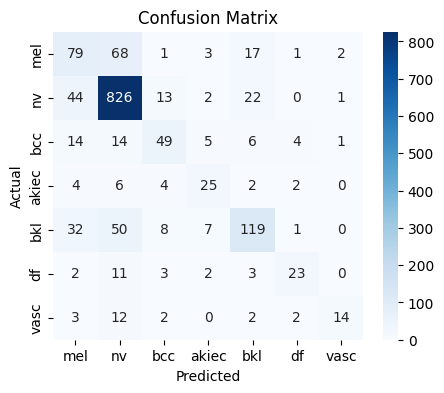

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)

              precision    recall  f1-score   support

         mel       0.44      0.46      0.45       171
          nv       0.84      0.91      0.87       908
         bcc       0.61      0.53      0.57        93
       akiec       0.57      0.58      0.57        43
         bkl       0.70      0.55      0.61       217
          df       0.70      0.52      0.60        44
        vasc       0.78      0.40      0.53        35

   micro avg       0.75      0.75      0.75      1511
   macro avg       0.66      0.56      0.60      1511
weighted avg       0.75      0.75      0.74      1511



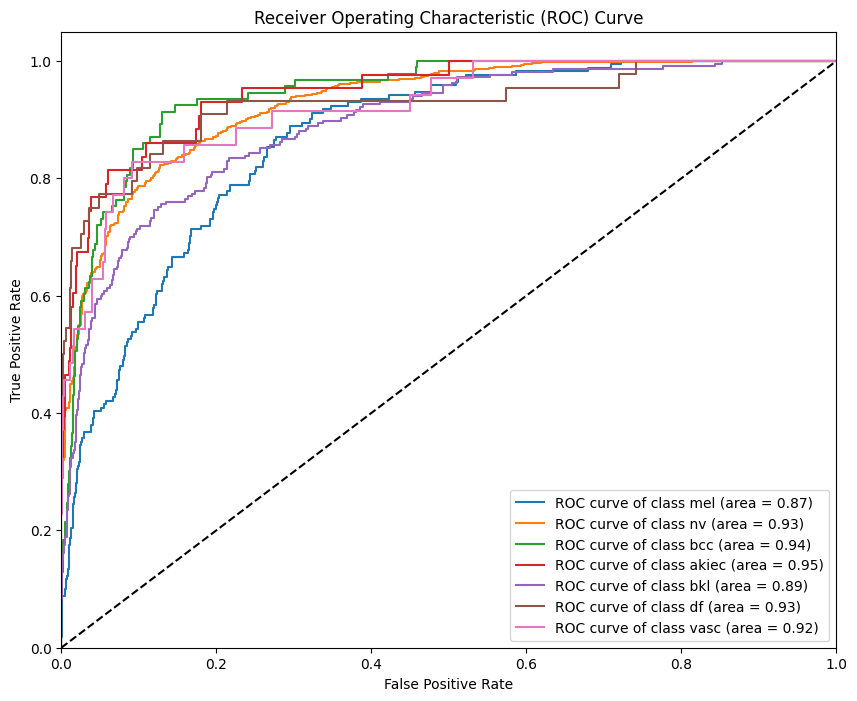

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tensorflow.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### metrics

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy = np.round(accuracy, 2)


# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
sensitivity = np.round(sensitivity, 2)

#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)
map_score = np.round(map_score, 2)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)
f1 = np.round(f1, 2)

# Positive Predictive Value (PPV) (Precision)
ppv = precision_score(true_classes, predicted_classes, average=None)
ppv = np.round(ppv, 2)


# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

npv = np.round(npv, 2)
specificity = np.round(specificity, 2)

In [ ]:
# Create a dictionary with all the metrics
metrics_dict = {
    'Class': target_names,
    'Accuracy': accuracy,
    #'Accuracy per class': per_class_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1,
    'MAP Score': map_score,
    'PPV (Precision)': ppv,
    'NPV': npv
}

# Create the dataframe
metrics_df = pd.DataFrame(metrics_dict)

In [ ]:
metrics_df

,Class,Accuracy,Sensitivity (Recall),Specificity,F1 Score,MAP Score,PPV (Precision),NPV
0,mel,0.75,0.46,0.93,0.45,0.49,0.44,0.93
1,nv,0.75,0.91,0.73,0.87,0.95,0.84,0.84
2,bcc,0.75,0.53,0.98,0.57,0.59,0.61,0.97
3,akiec,0.75,0.58,0.99,0.57,0.61,0.57,0.99
4,bkl,0.75,0.55,0.96,0.61,0.67,0.70,0.93
5,df,0.75,0.52,0.99,0.60,0.67,0.70,0.99
6,vasc,0.75,0.40,1.00,0.53,0.54,0.78,0.99


# Transfer learning with fine tunning

In [ ]:
# Fine-tuning: unfreeze a few layers of the base model
for layer in base_model.layers[-40:]:  # Unfreeze the last 7 layers
    layer.trainable = True


In [ ]:
#optimizer_ = Adam(learning_rate=0.0001)
optimizer_ = tf.keras.optimizers.Adamax(learning_rate=0.0001)
#optimizer_ = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

In [ ]:
# Compile the model with a lower learning rate for fine-tuning
transfer_fine_tune_model = Model(inputs=base_model.input, outputs=output)
transfer_fine_tune_model.compile(optimizer=optimizer_,
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
transfer_fine_tune_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,670,151 (97.92 MB)

 Trainable params: 17,339,399 (66.14 MB)

 Non-trainable params: 8,330,752 (31.78 MB)

In [ ]:
# Fine-tune the model
transfer_fine_tune_history = transfer_fine_tune_model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    #initial_epoch=transfer_history.epoch[-1],  # Continue training after transfer learning
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 380s 676ms/step - accuracy: 0.6762 - loss: 0.9559 - precision_1: 0.8115 - recall_1: 0.5663 - val_accuracy: 0.7344 - val_loss: 0.7807 - val_precision_1: 0.8104 - val_recall_1: 0.6699 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8750 - loss: 0.5542 - precision_1: 0.9600 - recall_1: 0.7500 - val_accuracy: 0.6842 - val_loss: 0.8567 - val_precision_1: 0.7857 - val_recall_1: 0.5789 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 615ms/step - accuracy: 0.7530 - loss: 0.6865 - precision_1: 0.8550 - recall_1: 0.6613 - val_accuracy: 0.7596 - val_loss: 0.6700 - val_precision_1: 0.8268 - val_recall_1: 0.6930 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7500 - loss: 0.6062 - precision_1: 0.8214 - recall_1: 0.7188 - val_accuracy: 0.6842 - val_loss: 0.7016 - val_precision_1: 0.7500 - val_recall_1: 0.6316 - learning_rate: 1.0000e-04
Epoch 

In [ ]:
# Evaluate the model on the validation/test set
#val_loss, val_accuracy = transfer_fine_tune_model.evaluate(val_generator)
#print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

val_loss, val_accuracy, val_precision, val_recall = transfer_fine_tune_model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.7712 - loss: 0.6189 - precision_1: 0.8161 - recall_1: 0.7319
Validation Loss: 0.5815024971961975, Validation Accuracy: 0.787319004535675, Validation Precision: 0.8279688954353333, Validation Recall: 0.7448827028274536


In [ ]:

# Combine the history of all three cases for accuracy and loss
acc_transfer = transfer_history.history['accuracy']
val_acc_transfer = transfer_history.history['val_accuracy']
loss_transfer = transfer_history.history['loss']
val_loss_transfer = transfer_history.history['val_loss']

acc_fine_tune = transfer_fine_tune_history.history['accuracy']
val_acc_fine_tune = transfer_fine_tune_history.history['val_accuracy']
loss_fine_tune = transfer_fine_tune_history.history['loss']
val_loss_fine_tune = transfer_fine_tune_history.history['val_loss']


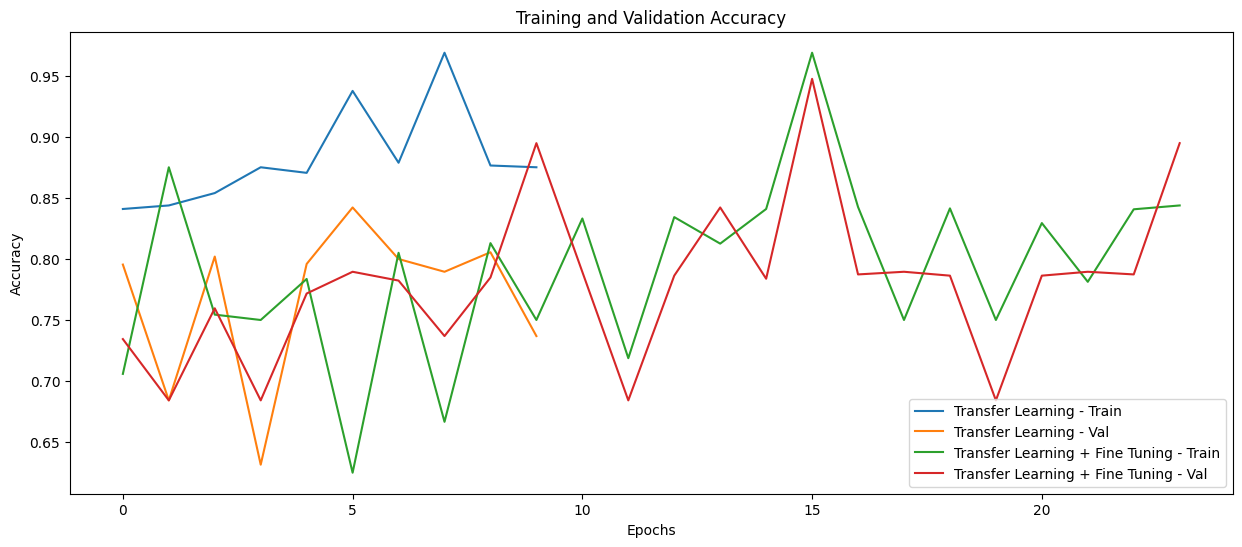

In [ ]:

# Plot Accuracy
plt.figure(figsize=(15, 6))

plt.plot(acc_transfer, label='Transfer Learning - Train')
plt.plot(val_acc_transfer, label='Transfer Learning - Val')

plt.plot(acc_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_acc_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

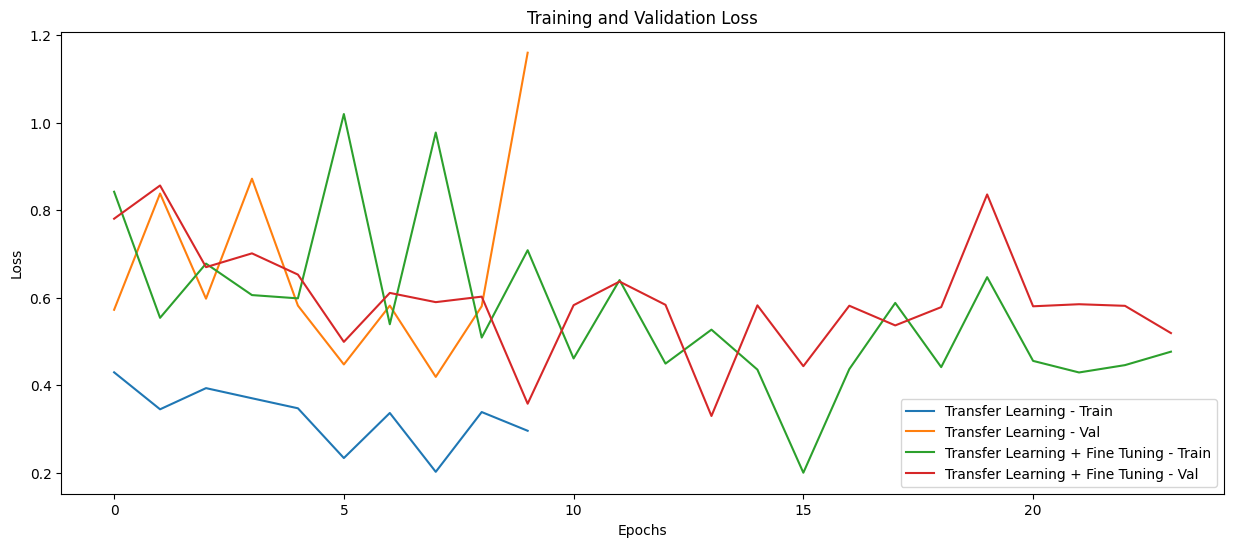

In [ ]:

# Plot Loss
plt.figure(figsize=(15, 6))

plt.plot(loss_transfer, label='Transfer Learning - Train')
plt.plot(val_loss_transfer, label='Transfer Learning - Val')

plt.plot(loss_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_loss_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()



In [ ]:

# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = transfer_fine_tune_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 ━━━━━━━━━━━━━━━━━━━━ 826s 17s/step


In [ ]:

len(predicted_classes)

1511

In [ ]:

# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes

array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy


0.7498345466578424

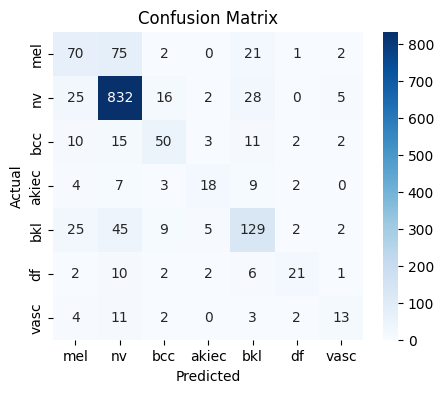

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)

              precision    recall  f1-score   support

         mel       0.50      0.41      0.45       171
          nv       0.84      0.92      0.87       908
         bcc       0.60      0.54      0.56        93
       akiec       0.60      0.42      0.49        43
         bkl       0.62      0.59      0.61       217
          df       0.70      0.48      0.57        44
        vasc       0.52      0.37      0.43        35

   micro avg       0.75      0.75      0.75      1511
   macro avg       0.62      0.53      0.57      1511
weighted avg       0.73      0.75      0.74      1511



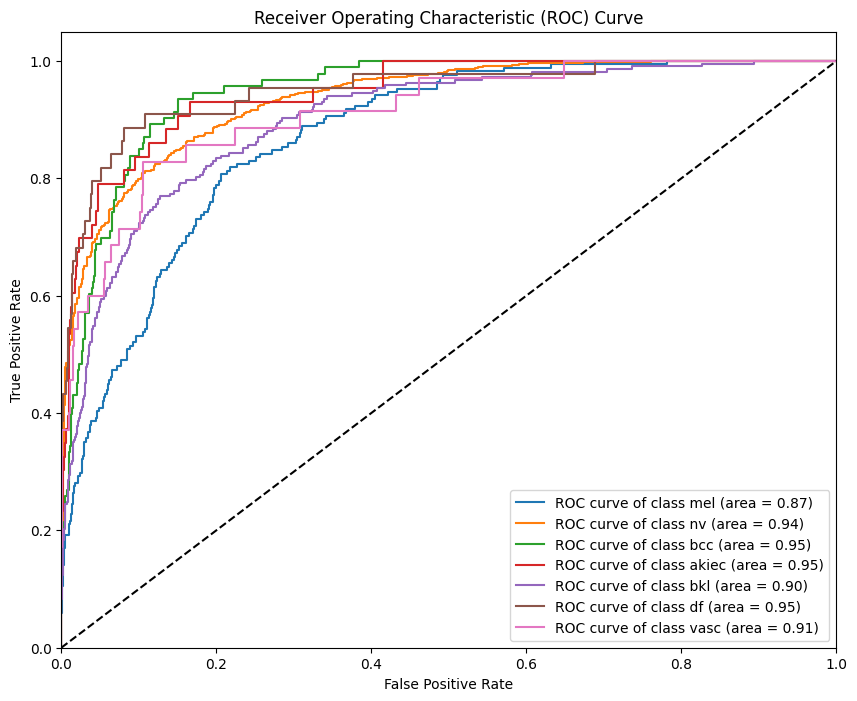

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tensorflow.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy = np.round(accuracy, 2)


# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
sensitivity = np.round(sensitivity, 2)

#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)
map_score = np.round(map_score, 2)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)
f1 = np.round(f1, 2)

# Positive Predictive Value (PPV) (Precision)
ppv = precision_score(true_classes, predicted_classes, average=None)
ppv = np.round(ppv, 2)


# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

npv = np.round(npv, 2)
specificity = np.round(specificity, 2)

In [ ]:
# Create a dictionary with all the metrics
metrics_dict = {
    'Class': target_names,
    'Accuracy': accuracy,
    #'Accuracy per class': per_class_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1,
    'MAP Score': map_score,
    'PPV (Precision)': ppv,
    'NPV': npv
}

# Create the dataframe
metrics_df = pd.DataFrame(metrics_dict)




In [ ]:
metrics_df

,Class,Accuracy,Sensitivity (Recall),Specificity,F1 Score,MAP Score,PPV (Precision),NPV
0,mel,0.75,0.41,0.95,0.45,0.52,0.50,0.93
1,nv,0.75,0.92,0.73,0.87,0.96,0.84,0.85
2,bcc,0.75,0.54,0.98,0.56,0.59,0.60,0.97
3,akiec,0.75,0.42,0.99,0.49,0.56,0.60,0.98
4,bkl,0.75,0.59,0.94,0.61,0.67,0.62,0.93
5,df,0.75,0.48,0.99,0.57,0.65,0.70,0.98
6,vasc,0.75,0.37,0.99,0.43,0.50,0.52,0.99


# Transfer learning with fine tunning and Balanced class weight

In [ ]:
# Fine-tuning: unfreeze a few layers of the base model
for layer in base_model.layers[-40:]:  # Unfreeze the last 7 layers
    layer.trainable = True

In [ ]:

transfer_fine_tune_balanced_model = Model(inputs=base_model.input, outputs=output)


In [ ]:
#optimizer_ = Adam(learning_rate=0.0001)
optimizer_ = tf.keras.optimizers.Adamax(learning_rate=0.0001)
#optimizer_ = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

In [ ]:
# 3. Compile the Model
transfer_fine_tune_balanced_model.compile(
    optimizer=optimizer_,
    loss='categorical_crossentropy',
   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [ ]:
transfer_fine_tune_balanced_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,670,151 (97.92 MB)

 Trainable params: 17,339,399 (66.14 MB)

 Non-trainable params: 8,330,752 (31.78 MB)

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to a dictionary
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
transfer_fine_tune_balanced_history = transfer_fine_tune_balanced_model.fit(
    train_generator,
    epochs=EPOCHS,  # Example number of epochs
    callbacks=[reduce_lr, early_stopping],
    #initial_epoch=transfer_fine_tune_history.epoch[-1],  # Continue training from previous fine-tuning stage
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict
)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 668ms/step - accuracy: 0.7555 - loss: 0.8326 - precision_2: 0.8157 - recall_2: 0.6876 - val_accuracy: 0.7414 - val_loss: 0.7271 - val_precision_2: 0.7929 - val_recall_2: 0.6946 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7500 - loss: 0.3777 - precision_2: 0.8000 - recall_2: 0.6250 - val_accuracy: 0.7895 - val_loss: 0.4704 - val_precision_2: 0.8750 - val_recall_2: 0.7368 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 180s 619ms/step - accuracy: 0.7563 - loss: 0.6716 - precision_2: 0.8306 - recall_2: 0.6941 - val_accuracy: 0.7117 - val_loss: 0.8180 - val_precision_2: 0.7533 - val_recall_2: 0.6648 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5938 - loss: 0.6288 - precision_2: 0.6923 - recall_2: 0.5625 - val_accuracy: 0.6842 - val_loss: 0.6950 - val_precision_2: 0.7500 - val_recall_2: 0.6316 - learning_rate: 1.0000e-04
Epoch 

In [ ]:

# Evaluate the model on the validation/test set
#val_loss, val_accuracy = transfer_fine_tune_balanced_model.evaluate(val_generator)
#print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

val_loss, val_accuracy, val_precision, val_recall = transfer_fine_tune_balanced_model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.7371 - loss: 0.7150 - precision_2: 0.7949 - recall_2: 0.6985
Validation Loss: 0.724618673324585, Validation Accuracy: 0.7418871521949768, Validation Precision: 0.7936145663261414, Validation Recall: 0.6949575543403625


In [ ]:

# Combine the history of all three cases for accuracy and loss
acc_transfer = transfer_history.history['accuracy']
val_acc_transfer = transfer_history.history['val_accuracy']
loss_transfer = transfer_history.history['loss']
val_loss_transfer = transfer_history.history['val_loss']

acc_fine_tune = transfer_fine_tune_history.history['accuracy']
val_acc_fine_tune = transfer_fine_tune_history.history['val_accuracy']
loss_fine_tune = transfer_fine_tune_history.history['loss']
val_loss_fine_tune = transfer_fine_tune_history.history['val_loss']


acc_fine_tune_balanced = transfer_fine_tune_balanced_history.history['accuracy']
val_acc_fine_tune_balanced = transfer_fine_tune_balanced_history.history['val_accuracy']
loss_fine_tune_balanced = transfer_fine_tune_balanced_history.history['loss']
val_loss_fine_tune_balanced = transfer_fine_tune_balanced_history.history['val_loss']


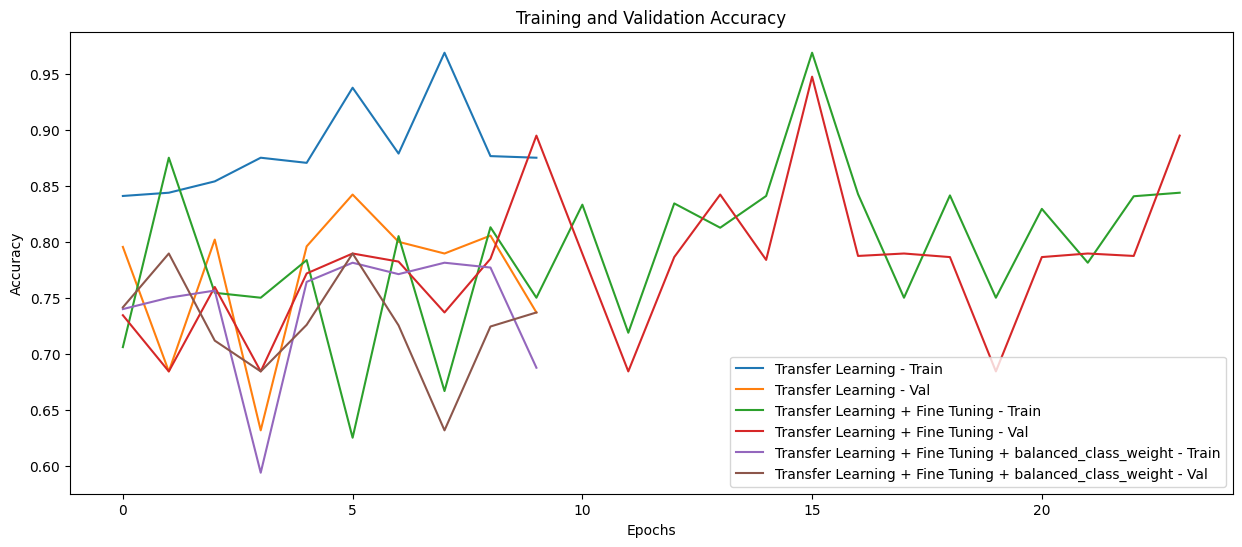

In [ ]:

# Plot Accuracy
plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 1)
plt.plot(acc_transfer, label='Transfer Learning - Train')
plt.plot(val_acc_transfer, label='Transfer Learning - Val')

plt.plot(acc_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_acc_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.plot(acc_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Train')
plt.plot(val_acc_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Val')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

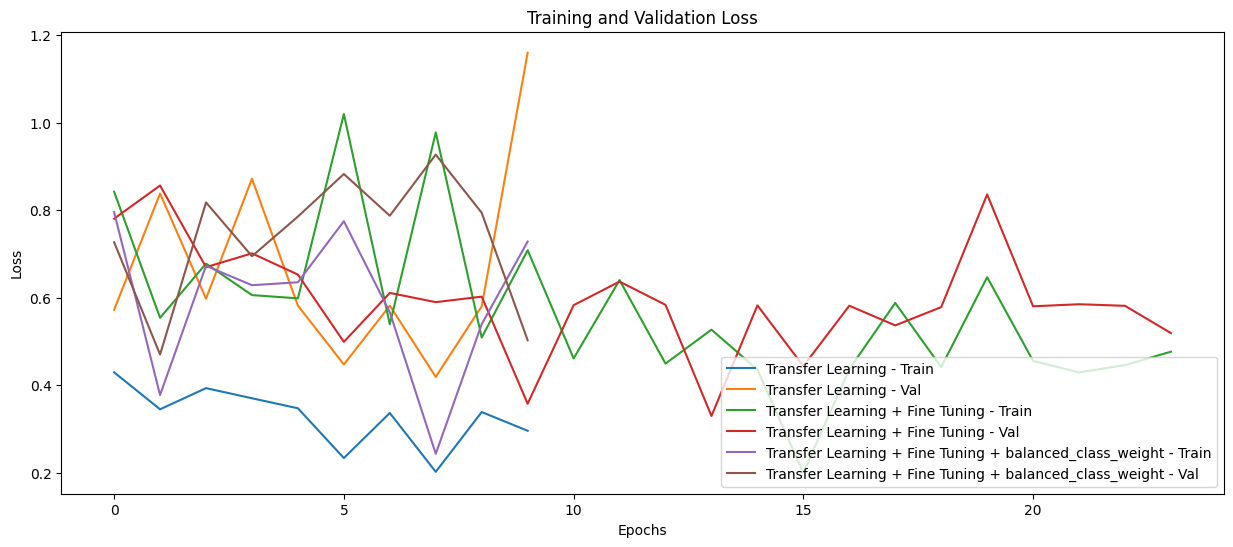

In [ ]:

# Plot Loss
plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 2)
plt.plot(loss_transfer, label='Transfer Learning - Train')
plt.plot(val_loss_transfer, label='Transfer Learning - Val')

plt.plot(loss_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_loss_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.plot(loss_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Train')
plt.plot(val_loss_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Val')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:

# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = transfer_fine_tune_balanced_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step


In [ ]:

len(predicted_classes)

1511

In [ ]:

# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes

array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy
#print(f'Accuracy: {accuracy:.2f}')



0.7174056915949703

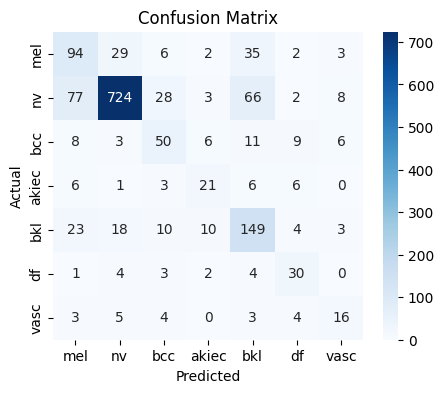

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)

              precision    recall  f1-score   support

         mel       0.44      0.55      0.49       171
          nv       0.92      0.80      0.86       908
         bcc       0.48      0.54      0.51        93
       akiec       0.48      0.49      0.48        43
         bkl       0.54      0.69      0.61       217
          df       0.53      0.68      0.59        44
        vasc       0.44      0.46      0.45        35

   micro avg       0.72      0.72      0.72      1511
   macro avg       0.55      0.60      0.57      1511
weighted avg       0.75      0.72      0.73      1511



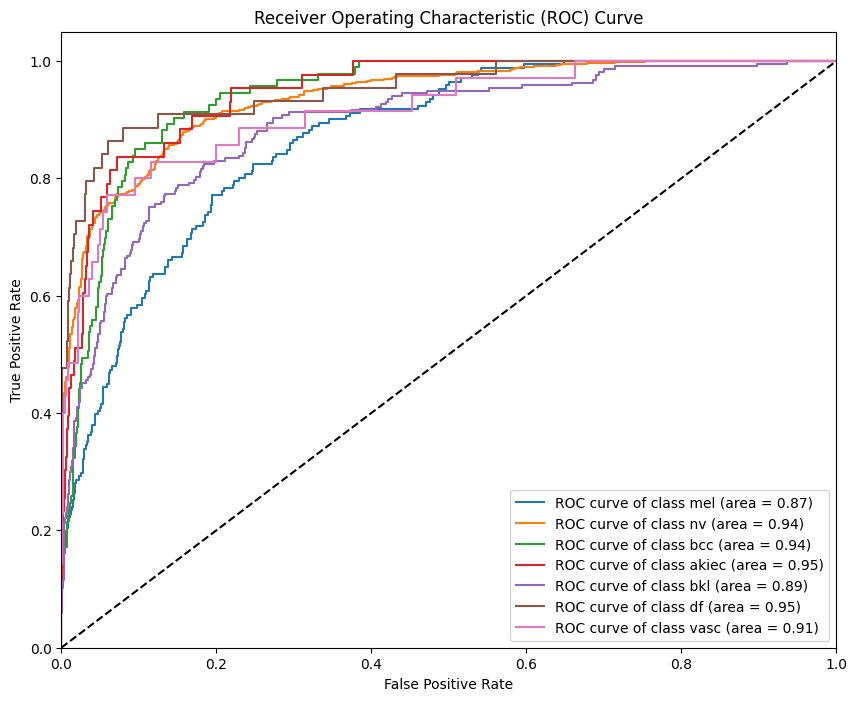

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tensorflow.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy = np.round(accuracy, 2)


# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
sensitivity = np.round(sensitivity, 2)

#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)
map_score = np.round(map_score, 2)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)
f1 = np.round(f1, 2)

# Positive Predictive Value (PPV) (Precision)
ppv = precision_score(true_classes, predicted_classes, average=None)
ppv = np.round(ppv, 2)


# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

npv = np.round(npv, 2)
specificity = np.round(specificity, 2)

In [ ]:
# Create a dictionary with all the metrics
metrics_dict = {
    'Class': target_names,
    'Accuracy': accuracy,
    #'Accuracy per class': per_class_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1,
    'MAP Score': map_score,
    'PPV (Precision)': ppv,
    'NPV': npv
}

# Create the dataframe
metrics_df = pd.DataFrame(metrics_dict)



In [ ]:
metrics_df

,Class,Accuracy,Sensitivity (Recall),Specificity,F1 Score,MAP Score,PPV (Precision),NPV
0,mel,0.72,0.55,0.91,0.49,0.53,0.44,0.94
1,nv,0.72,0.80,0.90,0.86,0.96,0.92,0.75
2,bcc,0.72,0.54,0.96,0.51,0.53,0.48,0.97
3,akiec,0.72,0.49,0.98,0.48,0.49,0.48,0.99
4,bkl,0.72,0.69,0.90,0.61,0.65,0.54,0.95
5,df,0.72,0.68,0.98,0.59,0.69,0.53,0.99
6,vasc,0.72,0.46,0.99,0.45,0.50,0.44,0.99


# Transfer learning with fine tunning and Effective Number of Samples

In [ ]:
def effective_num_class_weights(train_labels, beta=0.99):

    # Get the number of samples for each class
    unique_classes, counts = np.unique(train_labels, return_counts=True)
    num_classes = len(unique_classes)

    # Calculate effective number of samples for each class
    effective_num = (1 - np.power(beta, counts)) / (1 - beta)

    # Compute class weights
    weights = 1 / effective_num
    weights = weights / np.sum(weights) * num_classes  # Normalize so sum(weights) = num_classes

    # Create class weights dictionary (for Keras)
    class_weights_dict = dict(zip(unique_classes, weights))

    return class_weights_dict


In [ ]:
# Fine-tuning: unfreeze a few layers of the base model
for layer in base_model.layers[-40:]:  # Unfreeze the last 7 layers
    layer.trainable = True

In [ ]:

transfer_fine_tune_effective_model = Model(inputs=base_model.input, outputs=output)


In [ ]:
#optimizer_ = Adam(learning_rate=0.0001)
optimizer_ = tf.keras.optimizers.Adamax(learning_rate=0.0001)
#optimizer_ = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

In [ ]:
# 3. Compile the Model
transfer_fine_tune_effective_model.compile(
    optimizer=optimizer_,
    loss='categorical_crossentropy',
   metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [ ]:
transfer_fine_tune_effective_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,670,151 (97.92 MB)

 Trainable params: 17,339,399 (66.14 MB)

 Non-trainable params: 8,330,752 (31.78 MB)

In [ ]:
"""
fine_tune_epochs = 10
fine_tune_effective_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs + fine_tune_effective_epochs
"""

'\nfine_tune_epochs = 10\nfine_tune_effective_epochs = 10\ntotal_epochs = EPOCHS + fine_tune_epochs + fine_tune_effective_epochs\n'

In [ ]:
class_weights_dict = effective_num_class_weights(train_generator.classes, beta=0.99)


In [ ]:
transfer_fine_tune_effective_history = transfer_fine_tune_effective_model.fit(
    train_generator,
    epochs=EPOCHS,  # Example number of epochs
    callbacks=[reduce_lr, early_stopping],
    #initial_epoch=transfer_fine_tune_history.epoch[-1],  # Continue training from previous fine-tuning stage
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict  # Apply effective class weights
)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 194s 692ms/step - accuracy: 0.8186 - loss: 0.4116 - precision_3: 0.8628 - recall_3: 0.7760 - val_accuracy: 0.7843 - val_loss: 0.5786 - val_precision_3: 0.8265 - val_recall_3: 0.7490 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9375 - loss: 0.1954 - precision_3: 0.9667 - recall_3: 0.9062 - val_accuracy: 0.4737 - val_loss: 1.1825 - val_precision_3: 0.5000 - val_recall_3: 0.4211 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 649ms/step - accuracy: 0.8493 - loss: 0.3546 - precision_3: 0.8854 - recall_3: 0.8136 - val_accuracy: 0.7944 - val_loss: 0.5787 - val_precision_3: 0.8307 - val_recall_3: 0.7641 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8750 - loss: 0.3927 - precision_3: 0.9333 - recall_3: 0.8750 - val_accuracy: 0.6842 - val_loss: 0.5651 - val_precision_3: 0.7222 - val_recall_3: 0.6842 - learning_rate: 1.0000e-04
Epoch 

In [ ]:

# Evaluate the model on the validation/test set
#val_loss, val_accuracy = transfer_fine_tune_effective_model.evaluate(val_generator)
#print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


val_loss, val_accuracy, val_precision, val_recall = transfer_fine_tune_effective_model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.7833 - loss: 0.5903 - precision_3: 0.8241 - recall_3: 0.7462
Validation Loss: 0.5843689441680908, Validation Accuracy: 0.781328022480011, Validation Precision: 0.8235942721366882, Validation Recall: 0.745881199836731


In [ ]:
# Combine the history of all three cases for accuracy and loss
acc_transfer = transfer_history.history['accuracy']
val_acc_transfer = transfer_history.history['val_accuracy']
loss_transfer = transfer_history.history['loss']
val_loss_transfer = transfer_history.history['val_loss']

acc_fine_tune = transfer_fine_tune_history.history['accuracy']
val_acc_fine_tune = transfer_fine_tune_history.history['val_accuracy']
loss_fine_tune = transfer_fine_tune_history.history['loss']
val_loss_fine_tune = transfer_fine_tune_history.history['val_loss']


acc_fine_tune_effective = transfer_fine_tune_effective_history.history['accuracy']
val_acc_fine_tune_effective = transfer_fine_tune_effective_history.history['val_accuracy']
loss_fine_tune_effective = transfer_fine_tune_effective_history.history['loss']
val_loss_fine_tune_effective = transfer_fine_tune_effective_history.history['val_loss']


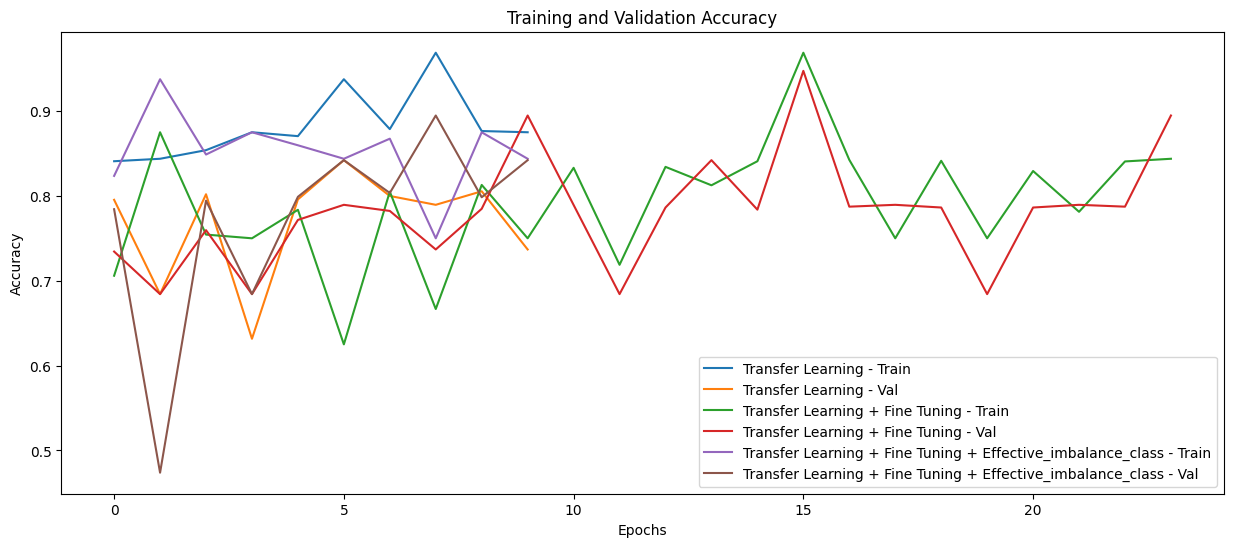

In [ ]:


# Plot Accuracy
plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 1)
plt.plot(acc_transfer, label='Transfer Learning - Train')
plt.plot(val_acc_transfer, label='Transfer Learning - Val')

plt.plot(acc_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_acc_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.plot(acc_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Train')
plt.plot(val_acc_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

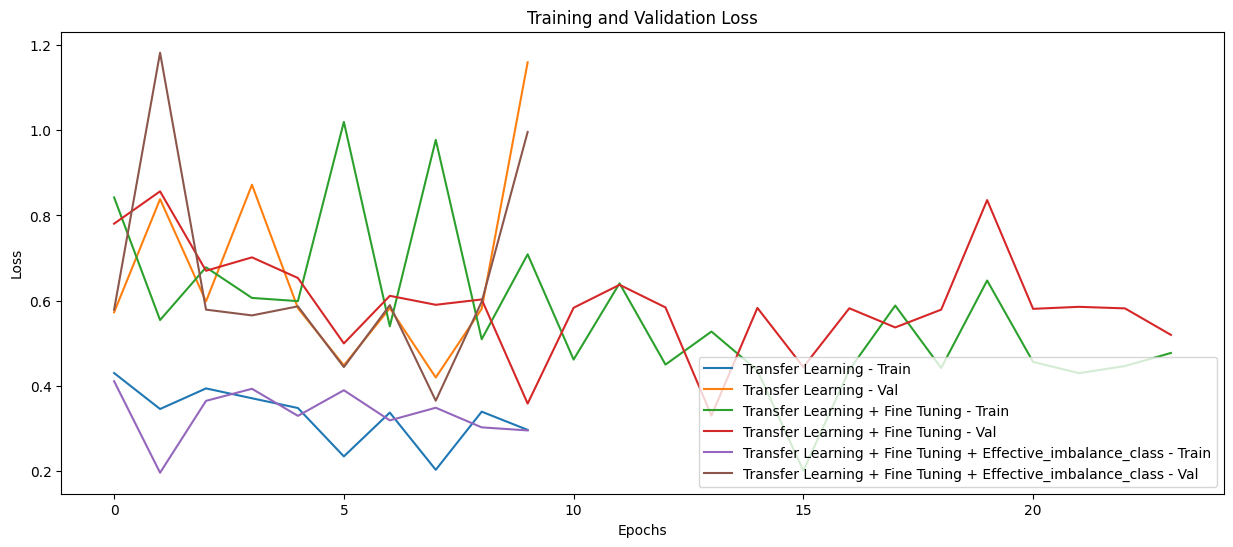

In [ ]:

# Plot Loss
plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 2)
plt.plot(loss_transfer, label='Transfer Learning - Train')
plt.plot(val_loss_transfer, label='Transfer Learning - Val')

plt.plot(loss_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_loss_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.plot(loss_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Train')
plt.plot(val_loss_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:

# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = transfer_fine_tune_effective_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step


In [ ]:

len(predicted_classes)

1511

In [ ]:

# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes

array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy
#print(f'Accuracy: {accuracy:.2f}')



0.7452018530774321

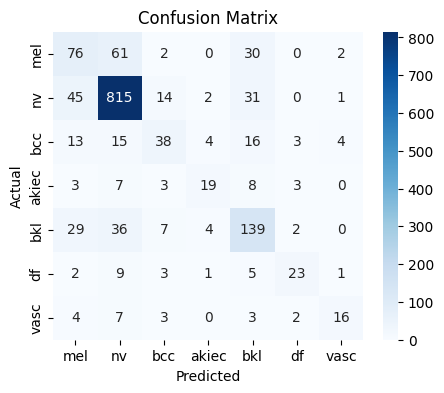

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)

              precision    recall  f1-score   support

         mel       0.44      0.44      0.44       171
          nv       0.86      0.90      0.88       908
         bcc       0.54      0.41      0.47        93
       akiec       0.63      0.44      0.52        43
         bkl       0.60      0.64      0.62       217
          df       0.70      0.52      0.60        44
        vasc       0.67      0.46      0.54        35

   micro avg       0.75      0.75      0.75      1511
   macro avg       0.63      0.54      0.58      1511
weighted avg       0.74      0.75      0.74      1511



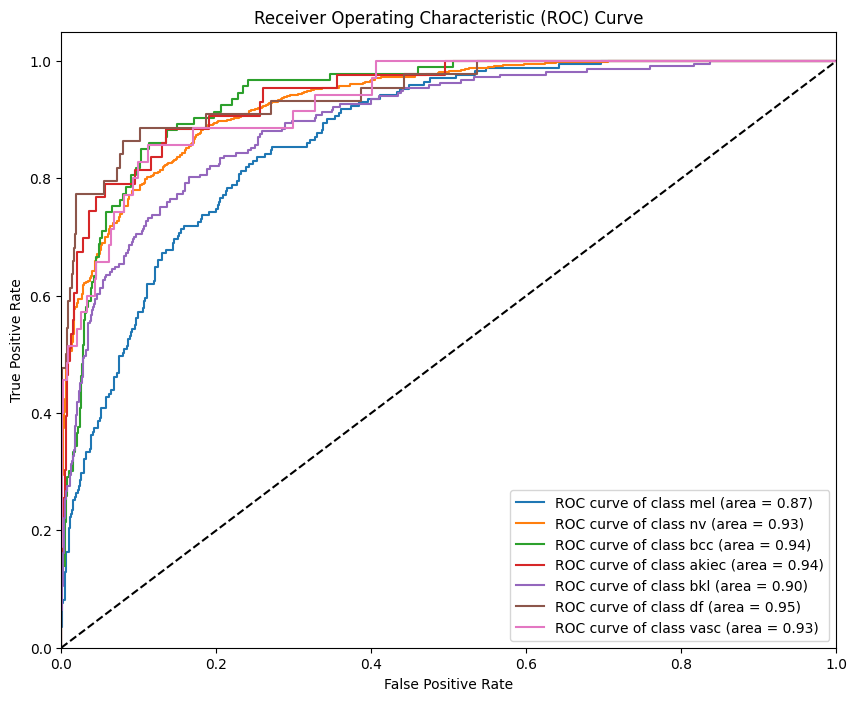

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tensorflow.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy = np.round(accuracy, 2)


# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
sensitivity = np.round(sensitivity, 2)

#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)
map_score = np.round(map_score, 2)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)
f1 = np.round(f1, 2)

# Positive Predictive Value (PPV) (Precision)
ppv = precision_score(true_classes, predicted_classes, average=None)
ppv = np.round(ppv, 2)


# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

npv = np.round(npv, 2)
specificity = np.round(specificity, 2)

In [ ]:
# Create a dictionary with all the metrics
metrics_dict = {
    'Class': target_names,
    'Accuracy': accuracy,
    #'Accuracy per class': per_class_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1,
    'MAP Score': map_score,
    'PPV (Precision)': ppv,
    'NPV': npv
}

# Create the dataframe
metrics_df = pd.DataFrame(metrics_dict)



In [ ]:
metrics_df

,Class,Accuracy,Sensitivity (Recall),Specificity,F1 Score,MAP Score,PPV (Precision),NPV
0,mel,0.75,0.44,0.93,0.44,0.49,0.44,0.93
1,nv,0.75,0.90,0.78,0.88,0.95,0.86,0.83
2,bcc,0.75,0.41,0.98,0.47,0.55,0.54,0.96
3,akiec,0.75,0.44,0.99,0.52,0.55,0.63,0.98
4,bkl,0.75,0.64,0.93,0.62,0.67,0.60,0.94
5,df,0.75,0.52,0.99,0.60,0.69,0.70,0.99
6,vasc,0.75,0.46,0.99,0.54,0.54,0.67,0.99


# Every comparison

In [ ]:

# Combine the history of all three cases for accuracy and loss
acc_transfer = transfer_history.history['accuracy']
val_acc_transfer = transfer_history.history['val_accuracy']
loss_transfer = transfer_history.history['loss']
val_loss_transfer = transfer_history.history['val_loss']

acc_fine_tune = transfer_fine_tune_history.history['accuracy']
val_acc_fine_tune = transfer_fine_tune_history.history['val_accuracy']
loss_fine_tune = transfer_fine_tune_history.history['loss']
val_loss_fine_tune = transfer_fine_tune_history.history['val_loss']


acc_fine_tune_balanced = transfer_fine_tune_balanced_history.history['accuracy']
val_acc_fine_tune_balanced = transfer_fine_tune_balanced_history.history['val_accuracy']
loss_fine_tune_balanced = transfer_fine_tune_balanced_history.history['loss']
val_loss_fine_tune_balanced = transfer_fine_tune_balanced_history.history['val_loss']


acc_fine_tune_effective = transfer_fine_tune_effective_history.history['accuracy']
val_acc_fine_tune_effective = transfer_fine_tune_effective_history.history['val_accuracy']
loss_fine_tune_effective = transfer_fine_tune_effective_history.history['loss']
val_loss_fine_tune_effective = transfer_fine_tune_effective_history.history['val_loss']


In [ ]:


# Plot Accuracy
plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 1)
plt.plot(acc_transfer, label='Transfer Learning - Train')
plt.plot(val_acc_transfer, label='Transfer Learning - Val')

plt.plot(acc_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_acc_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.plot(acc_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Train')
plt.plot(val_acc_fine_tune_balanced, label='Transfer + Fine Tuning + balanced_class_weight - Val')

plt.plot(acc_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Train')
plt.plot(val_acc_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Val')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:

# Plot Loss
plt.figure(figsize=(15, 6))
#plt.subplot(1, 2, 2)
plt.plot(loss_transfer, label='Transfer Learning - Train')
plt.plot(val_loss_transfer, label='Transfer Learning - Val')

plt.plot(loss_fine_tune, label='Transfer Learning + Fine Tuning - Train')
plt.plot(val_loss_fine_tune, label='Transfer Learning + Fine Tuning - Val')

plt.plot(loss_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Train')
plt.plot(val_loss_fine_tune_balanced, label='Transfer Learning + Fine Tuning + balanced_class_weight - Val')

plt.plot(loss_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Train')
plt.plot(val_loss_fine_tune_effective, label='Transfer Learning + Fine Tuning + Effective_imbalance_class - Val')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()